<a href="https://colab.research.google.com/github/Saanimustapha/AbaloneAgePrediction/blob/main/Group15_RidgeRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time
import math

In [ ]:
data = pd.read_csv('abalone.csv')

In [ ]:
numeric_cols = data.select_dtypes(include=[np.number]).columns

factor = 1.5

for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    data[col] = np.clip(data[col], lower_bound, upper_bound)

In [ ]:
data_encoded = pd.get_dummies(data, columns=['sex'])

In [ ]:
data_encoded.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15.0,False,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7.0,False,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9.0,True,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10.0,False,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7.0,False,True,False


In [ ]:
X = data_encoded.drop(columns=[' rings'])
y = data_encoded[' rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'ridge__alpha': np.logspace(-7, 5, 25),
    'ridge__max_iter': [1000, 5000, 10000, 20000],
    'ridge__tol': [1e-4, 1e-3, 1e-2],
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'ridge__fit_intercept': [True, False]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f'Training time: {training_time:.2f} seconds')

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Get the best pipeline
best_pipeline = grid_search.best_estimator_

# Make predictions
y_pred = best_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(f'Root mean Squared Error with best parameters: {rmse}')

# Get the coefficients of the best Ridge model
best_ridge = best_pipeline.named_steps['ridge']
print(f'Coefficients: {best_ridge.coef_}')


Training time: 499.70 seconds
Best parameters: {'ridge__alpha': 0.03162277660168379, 'ridge__fit_intercept': True, 'ridge__max_iter': 10000, 'ridge__solver': 'sag', 'ridge__tol': 0.01}
Root mean Squared Error with best parameters: 1.7970654498310483
Coefficients: [ 0.13217799  0.98895052  0.66624932  3.17110341 -3.64163842 -0.76076314
  0.85109791  0.12011679 -0.27511266  0.14896791]


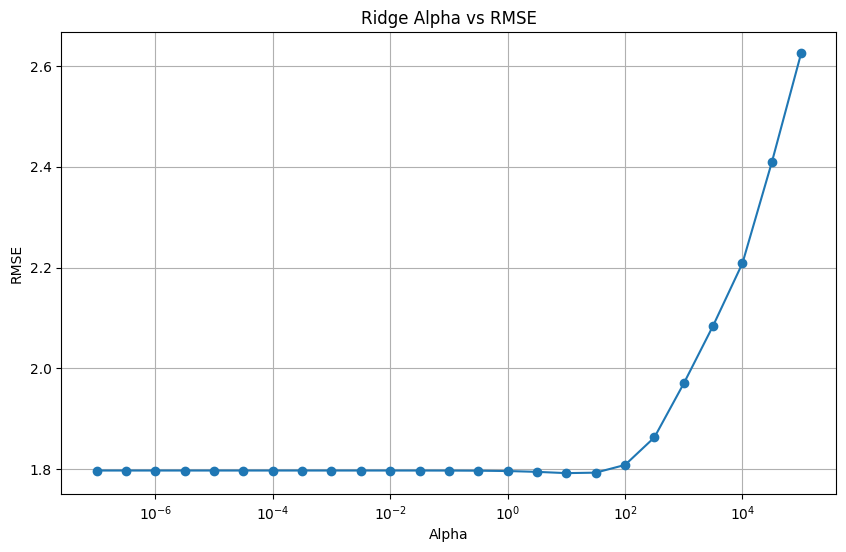

In [ ]:
# Define the range of alpha values
alpha_values = np.logspace(-7, 5, 25)
rmse_values = []

# Loop through alpha values, fit the model, and calculate RMSE
for alpha in alpha_values:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=alpha, max_iter=10000))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    rmse_values.append(rmse)

# Plot alpha vs RMSE
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, rmse_values, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Ridge Alpha vs RMSE')
plt.grid(True)
plt.show()